## Example 1

### This example show the usage of HMAP. HMAP supports both unsupervised and supervised modes. The following code runs HMAP under the unsupervised mode. Another tutorial shows how to use HMAP with the supervised mode.

In [1]:
import os 
import subprocess


import pandas as pd
import numpy as np
import scanpy as sc
import networkx as nx 

import datatable as dt
import umap 

from HMAP import HMAPSC
from SURE.assembly import get_data
from sklearn.preprocessing import OneHotEncoder


import torch
torch.set_float32_matmul_precision("high")


/home/oem/anaconda3/envs/pyro/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


2025-03-06 16:54:01.961222: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 16:54:01.969139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 16:54:01.982038: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 16:54:01.986011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 16:54:01.995666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

#### The dataset used can be fetched from the NCBI GEO database. [HERE](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122)

### Select highly variable genes according to the Scanpy's document

In [2]:
adata = sc.read_h5ad('GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
adata = adata[:,adata.var['feature_types'].isin(['GEX'])]
adata.X = adata.layers['counts'].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch', subset=True)

adata.shape

(69249, 2000)

### Model configuration

In [3]:
batch_key = 'batch'
ident_key = 'cell_type'
batch_size = 1000    # the number of cells for modeling training per batch
codebook_size = 30   # the number of metacells
z_dist='normal'      # distribution models for local embedding
d_dist='normal'      # distribution models for global embedding
likeli='negbinomial' # probabilistic model for generating cellular data

In [5]:
xs = adata.layers['counts'].toarray()
input_size = xs.shape[1]

enc = OneHotEncoder(sparse_output=False).fit(adata.obs[batch_key].to_numpy().reshape(-1,1))
us = enc.transform(adata.obs[batch_key].to_numpy().reshape(-1,1))
undesired_size = us.shape[1]

### Initialize HMAP and train the model.

In [7]:
hmap = HMAPSC(input_size=input_size,
               undesired_size=undesired_size,
               codebook_size=codebook_size,
               supervised_mode=False,
               hidden_layers=[100],
               d_dist=d_dist,
               z_dist=z_dist,
               loss_func=likeli,
               use_cuda=True)

In [8]:
hmap.fit(xs, us=us, 
         batch_size=batch_size)
HMAPSC.save_model(hmap, file_path='temp_hmap_model.pth.gz', compression='gzip')

100%|██████████| 68/68 [00:00<00:00, 146.57batch/s]


Model saved to /home/oem/Workspace/Multiome_NIPS2021/temp_hmap_model.pth.gz


In [9]:
model = HMAPSC.load_model('temp_hmap_model.pth.gz')

Model loaded from temp_hmap_model.pth.gz


### Visualization of global and local embeddings

In [10]:
adata.obsm['X_hmap_l1'] = model.get_l1_embedding(xs)    # global embedding
adata.obsm['X_hmap_l2'] = model.get_l2_embedding(xs)     # local embedding

adata.obsm['X_HMAP_Global'] = adata.obsm['X_hmap_l1']
adata.obsm['X_HMAP_Local'] = umap.UMAP().fit_transform(adata.obsm['X_hmap_l2'])

100%|██████████| 68/68 [00:00<00:00, 167.64batch/s]


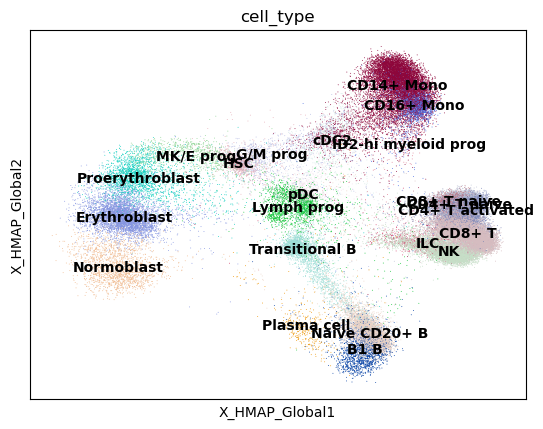

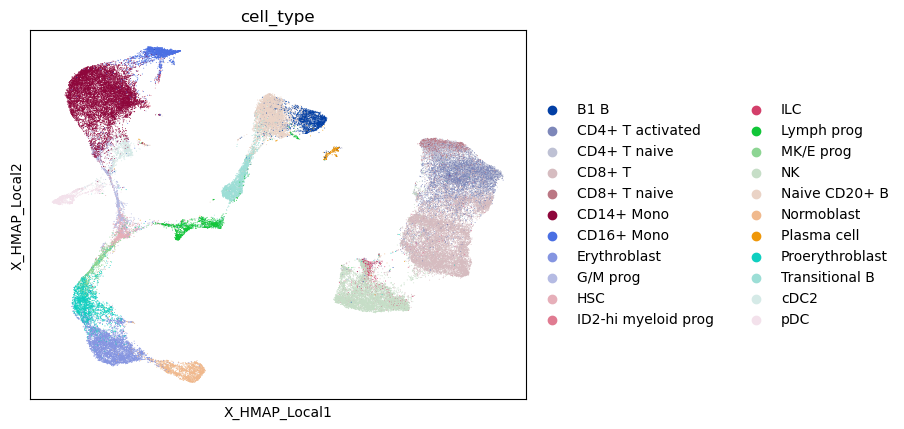

In [11]:
sc.pl.embedding(adata, basis='X_HMAP_Global', color=['cell_type'], legend_loc='on data')
sc.pl.embedding(adata, basis='X_HMAP_Local', color=['cell_type'])